In [315]:
import numpy as np
import os
import pandas as pd
from matplotlib import mlab
import matplotlib.pyplot as plt

from src.data.make_dataset import BCIDataset
from src.visualization.plotting import plot_data, plot_data_logvar
from src.data.signal_processing import best_csp_components

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [316]:
classes = {'hand_right': 0, 'hand_left': 1, 'wrist_right': 2, 'wrist_left': 3}
subjects = ["anna"]
measurements = ["2023-02-20_17-52-36_with_timecorr"]

In [317]:
data_root = "C:/Users/annag/OneDrive - Danmarks Tekniske Universitet/Semester_04/Special_Course_BCI/03_code/BCI_stroke_rehab/data/raw/"

# Create data class

In [318]:
mydataset = BCIDataset(data_root, subjects, measurements)

In [319]:
mydataset.data.head()

,subject,measurement,class,sampleID,path,sample
0,anna,2023-02-20_17-52-36_with_timecorr,arm_left,10,arm_left_10_1676912164.csv,Unnamed: 0 class time_in_s C...
1,anna,2023-02-20_17-52-36_with_timecorr,arm_left,11,arm_left_11_1676912181.csv,Unnamed: 0 class time_in_s C...
2,anna,2023-02-20_17-52-36_with_timecorr,arm_left,13,arm_left_13_1676912214.csv,Unnamed: 0 class time_in_s C...
3,anna,2023-02-20_17-52-36_with_timecorr,arm_left,15,arm_left_15_1676912247.csv,Unnamed: 0 class time_in_s C...
4,anna,2023-02-20_17-52-36_with_timecorr,arm_left,18,arm_left_18_1676912297.csv,Unnamed: 0 class time_in_s C...


### Get shapes

In [320]:
mydataset.get_shapes()

{'n_channels': 16,
 'sample_length': 500,
 'n_classes': {'arm_left': 20, 'arm_right': 20}}

### Get one sample

In [321]:
sample_idx = 4
sample, label = mydataset[sample_idx]
sample.head()

,Unnamed: 0,class,time_in_s,CZ,C4,T4,T5,P3,PZ,P4,FZ,FP1,FP2,F7,F3,F4,F8,T3,C3
60,60,arm_left,0.478903,5.720519,7.170051,-1.015880,-8.826417,15.914831,13.300872,12.293798,9.637943,16.786201,10.751007,14.106123,3.124084,11.618855,8.156401,23.688427,16.437571
61,61,arm_left,0.486888,-25.124443,-26.448851,-36.119045,-0.080308,-18.624149,-14.879508,-20.099859,-27.962715,-18.898006,-21.415771,-20.618231,-9.016936,-22.831263,-28.160774,17.427219,-15.262840
62,62,arm_left,0.494874,-4.951201,-2.971323,-5.884944,10.639587,3.014653,2.482399,-2.816104,-6.836740,-19.341133,-16.008986,-18.591274,-13.551664,-18.856222,-21.234612,24.750261,-18.665901
63,63,arm_left,0.502859,16.184975,19.337753,17.916210,4.163707,19.636646,22.430016,17.283268,15.684902,11.106608,17.178246,10.460999,5.530316,13.391033,15.248152,21.313625,8.609676
64,64,arm_left,0.510845,-7.274135,-6.403828,-8.653991,-0.005878,-15.326625,3.796597,-3.965733,-10.091602,-0.084922,7.124174,-2.083919,-0.659661,3.848733,4.214858,6.005229,-0.783028


In [322]:
timestamps = np.array(sample['time_in_s'])

In [323]:
np.ediff1d(timestamps)[0:40]

array([0.0079856 , 0.00798561, 0.00798562, 0.00798562, 0.00797688,
       0.0079769 , 0.00797691, 0.00797692, 0.00797693, 0.00797795,
       0.00797796, 0.00797798, 0.00797799, 0.007978  , 0.00798121,
       0.00798122, 0.00798123, 0.00798123, 0.00798124, 0.00798293,
       0.00798294, 0.00798294, 0.00798295, 0.00798296, 0.00798682,
       0.00798682, 0.00798682, 0.00798683, 0.00798683, 0.00797821,
       0.00797822, 0.00797823, 0.00797824, 0.00797826, 0.00797992,
       0.00797993, 0.00797994, 0.00797995, 0.00797996, 0.00798476])

## Validate data

In [324]:
mydataset.validate_data()

Total invalid samples: 2


In [325]:
sample_values = mydataset.get_sample_values(3, selected_data="sample")
np.shape(sample_values[:,3])

(500,)

### Plot PSD of Raw Data

(38, 251, 16)


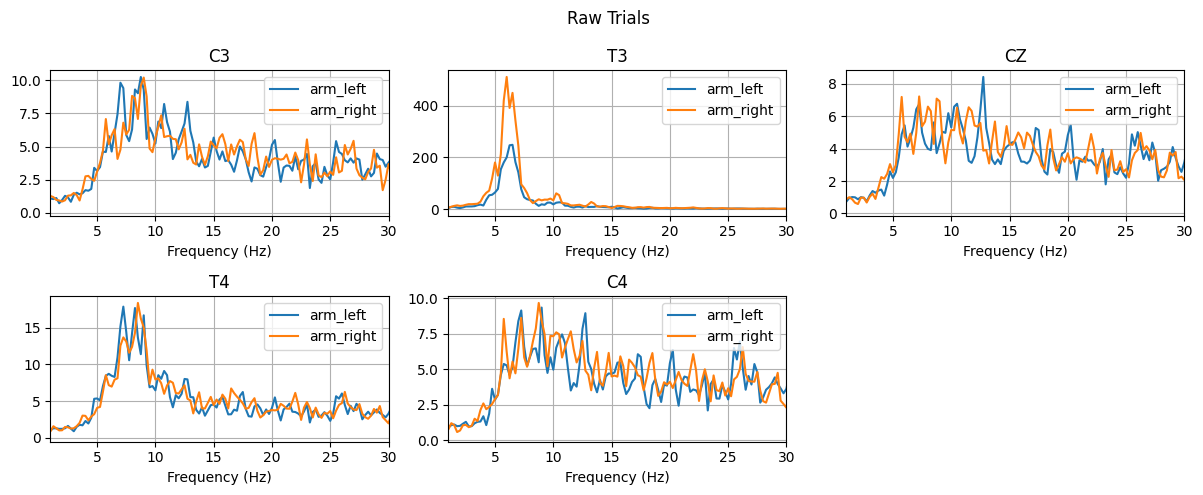

In [326]:
plot_data(mydataset, title="Raw Trials", selected_data="sample")

# Preprocess data

## Bandpass Filter

In [327]:
mydataset.apply_bandpass_filtering(selected_data="sample")

### Plot PSD of filtered data

(38, 251, 16)


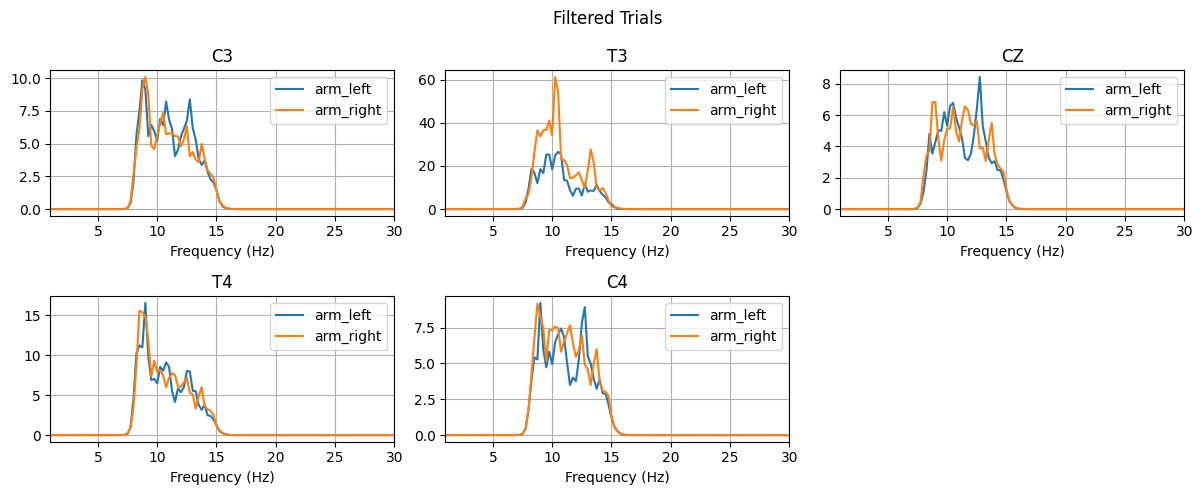

In [328]:
plot_data(mydataset, title="Filtered Trials", selected_data="filtered")

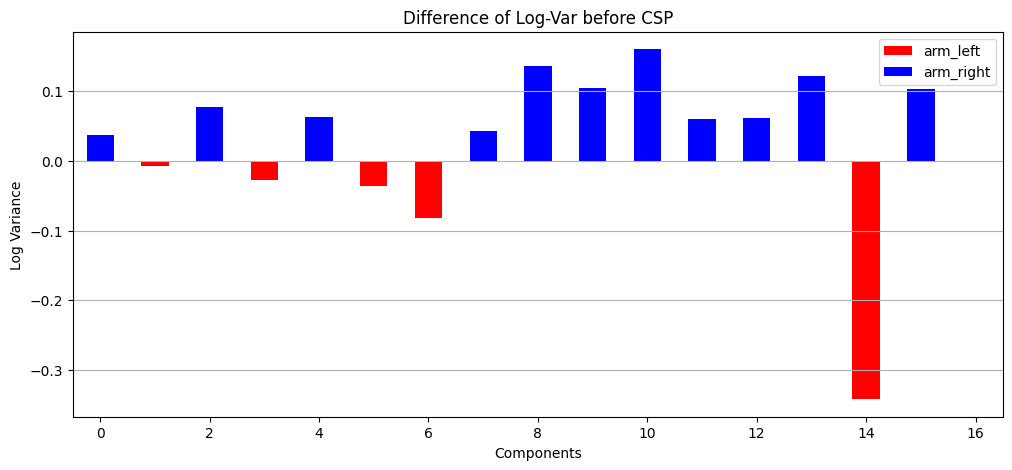

In [329]:
plot_data_logvar(mydataset, selected_data="filtered", mode="diff", title="before CSP")

## CSP (Common Spatial Pattern)

CSP designs a set of spatial filters so that the filtered signal’s variance is maximal for one class while minimal for the other one.
It estimates the spatial covariance for each EEG trial with size (n_channels, n_samples).

In [330]:
csp_Matrix = mydataset.calc_csp(only_train=False, selected_data='filtered')
mydataset.apply_csp(selected_data="filtered")

(38, 251, 16)


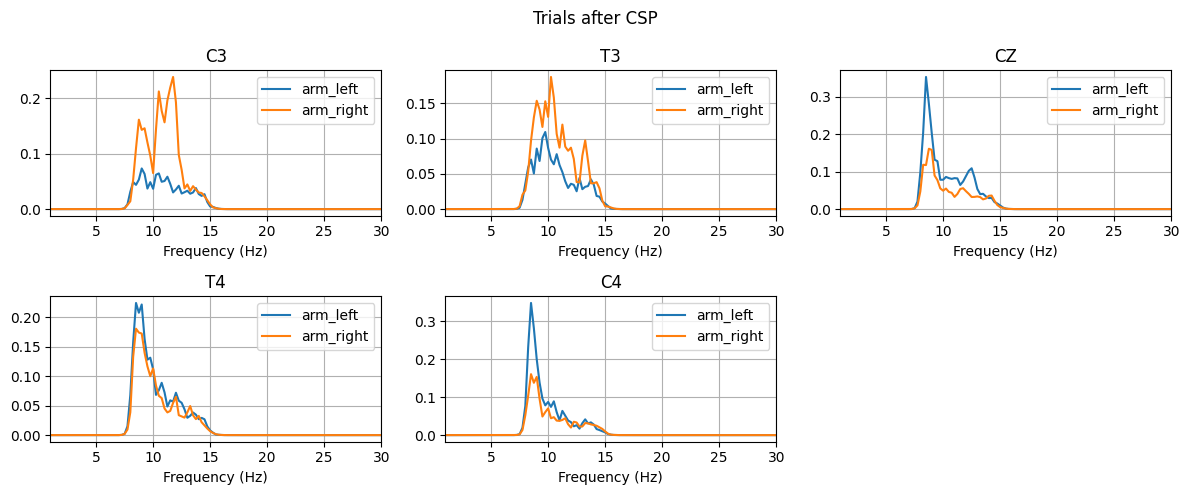

In [331]:
plot_data(mydataset, title="Trials after CSP", selected_data="csp")

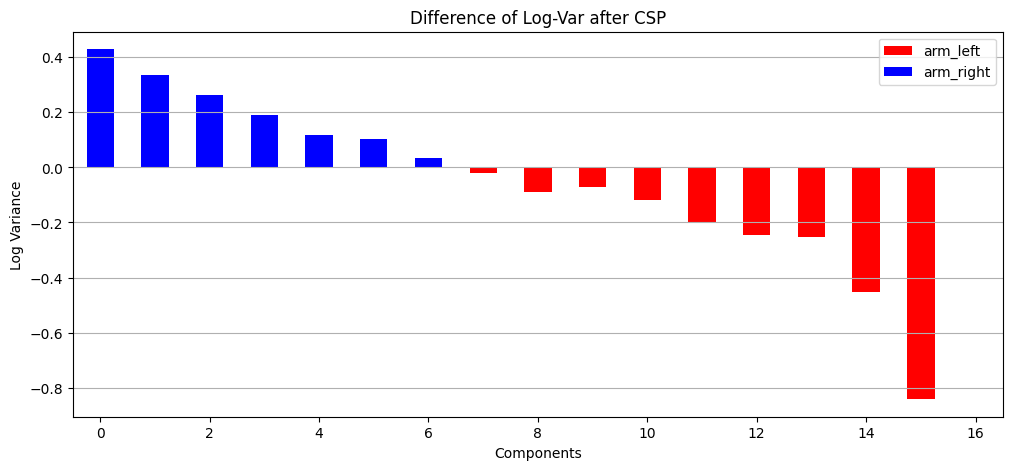

In [332]:
plot_data_logvar(mydataset, selected_data="csp", mode="diff", title="after CSP")

## Choose best components

Components with highest difference of log-variance between both classes

In [334]:
data_2comp = mydataset.feature_extraction_CSP(only_train=False)
print(np.shape(data_2comp))

Best CSP components: [0, 15]
(38, 500, 2)
